<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

## 1. Adding Preferential Attachment Feature

We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

In [4]:
train_graph=nx.read_edgelist('./data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [5]:
# df_final_train.drop([50057], inplace=True) 484879

In [6]:
def preferentialAttachment(a,b):
    # The nodes in nbunch are checked for membership in the graph and if not then we will return 0.
    try:
        return train_graph.in_degree(a)*train_graph.in_degree(b)
    
    except nx.NetworkXError:
        return 0

In [7]:
#mapping preferential attachment on train
df_final_train['Pref_Attach'] = df_final_train.apply(lambda row: preferentialAttachment(row['source_node'],row['destination_node']),axis=1)
#mapping preferential attachment on test
df_final_test['Pref_Attach'] = df_final_test.apply(lambda row: preferentialAttachment(row['source_node'],row['destination_node']),axis=1)


## 2. Adding svd_dot Feature

In [8]:
def svd(x,S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [9]:
def valueMultiplication(a,b):
    return np.dot(a,b)

In [10]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [11]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [12]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [13]:
valueMultiplication(svd(1,U),svd(5,U))

-5.653992945881712e-32

In [14]:
#mapping SVD Dot on train
df_final_train['svd_dot_u'] = df_final_train.apply(lambda row: valueMultiplication(svd(row['source_node'],U),svd(row['destination_node'],U)),axis=1)
#mapping SVD Dot on test
df_final_test['svd_dot_u'] = df_final_test.apply(lambda row: valueMultiplication(svd(row['source_node'],U),svd(row['destination_node'],U)),axis=1)


In [15]:
#mapping SVD Dot on train
df_final_train['svd_dot_v'] = df_final_train.apply(lambda row: valueMultiplication(svd(row['source_node'],V.T),svd(row['destination_node'],V.T)),axis=1)
#mapping SVD Dot on test
df_final_test['svd_dot_v'] = df_final_test.apply(lambda row: valueMultiplication(svd(row['source_node'],V.T),svd(row['destination_node'],V.T)),axis=1)


In [18]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [26]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## 3. Applying XGBoost 

In [40]:
# Save to file in the current working directory
def saveModel(fileName,model):  
    with open(fileName, 'wb') as file:  
        pickle.dump(model, file)

In [41]:
# Load from file
def getModel(pkl_filename):
    with open(pkl_filename, 'rb') as file:  
        pickle_model = pickle.load(file)
    return pickle_model

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Model Training
clf = XGBClassifier(random_state=25,n_jobs=-1)
parameters = {"max_depth":[1, 5, 10, 50, 100, 500, 1000],
              "n_estimators": [1, 2, 4, 8, 16, 32, 64, 100, 200]} 

model = GridSearchCV(clf, parameters, cv=5,verbose=10, scoring='f1')
model.fit(df_final_train, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, n_estimators=1, score=0.7138635487601181, total=   0.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.7192118226600985, total=   0.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.7129540340726455, total=   0.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.7088868824970979, total=   0.8s
[CV] max_depth=1, n_estimators=1 .....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=1, score=0.7154315046519089, total=   0.8s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.8707924001396299, total=   0.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.869884832148983, total=   0.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.8679931220830264, total=   0.9s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.0s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.8652587013242751, total=   0.8s
[CV] max_depth=1, n_estimators=2 .....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.1s remaining:    0.0s


[CV]  max_depth=1, n_estimators=2, score=0.8661200844420442, total=   0.9s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.8485650198424111, total=   1.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.8567186340014847, total=   1.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.8498879761015683, total=   1.0s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.851010101010101, total=   1.1s
[CV] max_depth=1, n_estimators=4 .....................................
[CV]  max_depth=1, n_estimators=4, score=0.8550185873605948, total=   1.0s
[CV] max_depth=1, n_estimators=8 .....................................
[CV]  max_depth=1, n_estimators=8, score=0.8517350157728707, total=   1.4s
[CV] max_depth=1, n_estimators=8 .................

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 250.1min finished


Best Hyperparameter: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [44]:
saveModel("XGBoostFBLinkPred.pkl",model)

Heatmap of <b>max_depth</b> and <b>n_estimators</b> parameters to find the areas where the maximum F1 score is achieved in the train & test set.

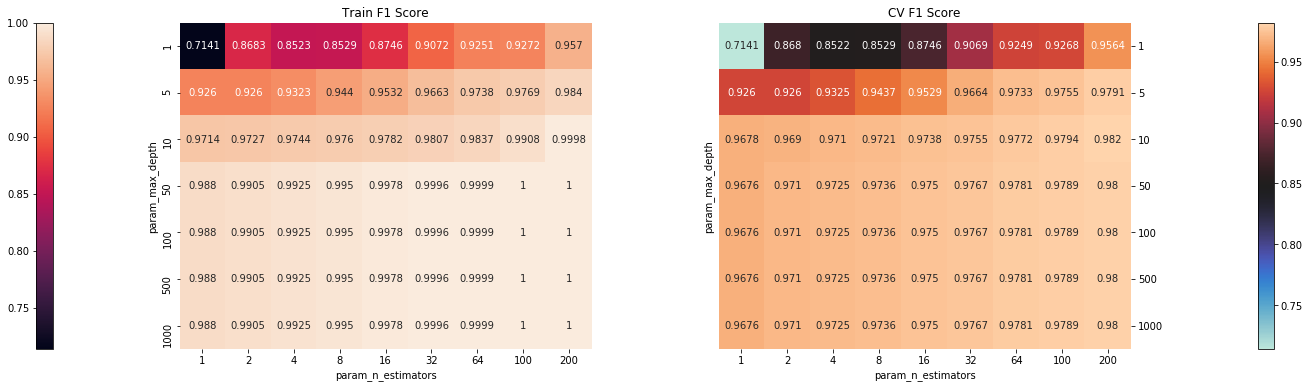

In [45]:
# https://stackoverflow.com/questions/48272437/combining-two-heat-maps-in-seaborn?rq=1

# Train vs CV auc score
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(25,6))
fig.subplots_adjust(wspace=0.2)
sns.heatmap(max_scores.mean_train_score,annot=True, fmt='.4g', cmap="rocket",ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(max_scores.mean_test_score,annot=True, fmt='.4g', cmap="icefire",ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False,pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
ax.title.set_text('Train F1 Score')
ax2.title.set_text('CV F1 Score')
plt.show()

In [47]:
# Testing accuracy on test dataset
clf = XGBClassifier( max_depth = bestParameter.max_depth, n_estimators = bestParameter.n_estimators)
clf.fit(df_final_train, y_train)

y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [48]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9996302329532394
Test f1 score 0.9264593423400459


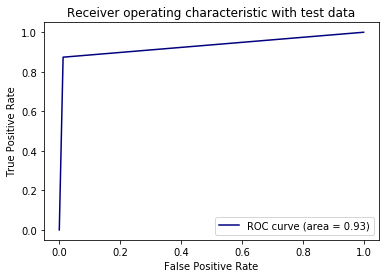

In [49]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


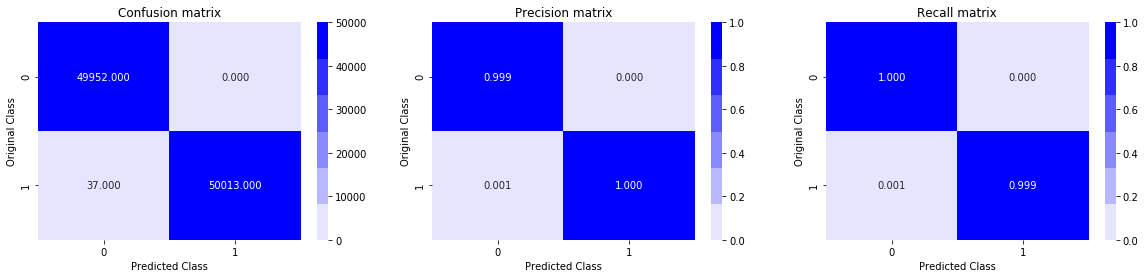

Test confusion_matrix


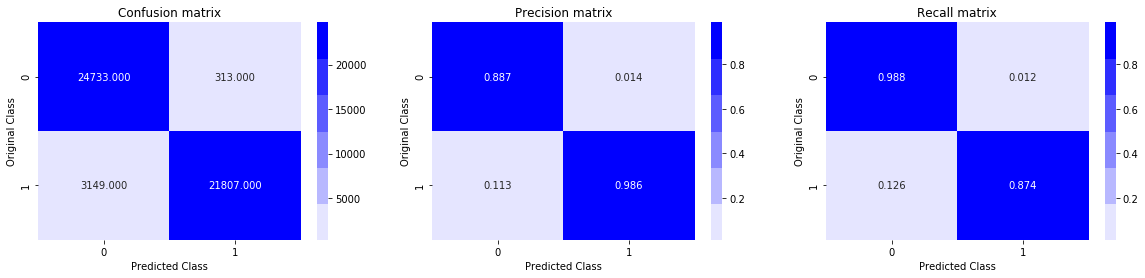

In [51]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

#### Feature Importance

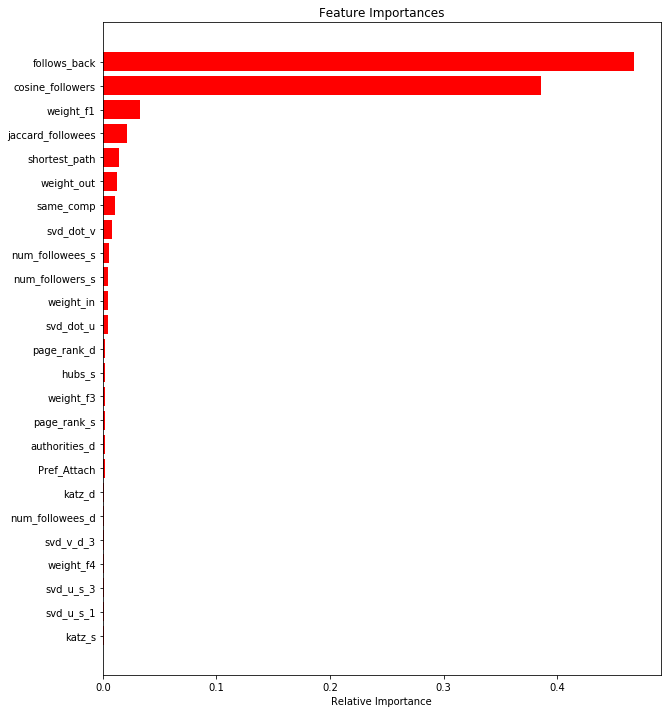

In [52]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Conclusion

* Oberservation(s):
    - The model failed to hold the F1 score observed during training. Considerable difference we see in test and train f1         score, hence model is overfitting.
    - precision for class 0 is less than class 1. Where as Recall for class 0 better than class 1.
    - svd_dot feature has higher preference than Preferential_attachment during classification.
    - Katz_s and other SVD features remains the least useful features. 

In [7]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model", "Hyperparameter: max_depth, n_estimators", "F1"]
x.add_row(["XGBoost","10, 200", "Train f1 score 0.998\nTest f1 score 0.926" ])
print(x)

+---------+-----------------------------------------+----------------------+
|  Model  | Hyperparameter: max_depth, n_estimators |          F1          |
+---------+-----------------------------------------+----------------------+
| XGBoost |                 10, 200                 | Train f1 score 0.998 |
|         |                                         | Test f1 score 0.926  |
+---------+-----------------------------------------+----------------------+
